在Automatic Speech Recognition的基础上，将预测序列，转变为预测整体类别，实现过程简单很多。使用相同模型，适当修改。

dataset：http://challenge.xfyun.cn/2018/aicompetition/tech

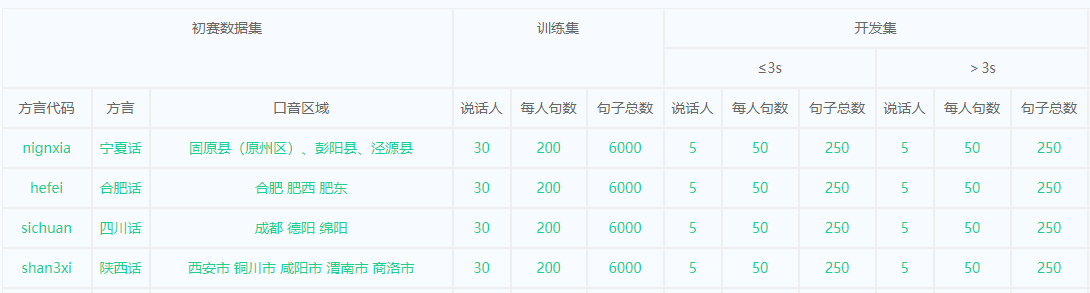

In [1]:
import numpy as np
import os
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
from sklearn.utils import shuffle
import glob
import pickle
from tqdm import tqdm_notebook

from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Activation, Conv1D, Add, Multiply, BatchNormalization, GlobalMaxPooling1D, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

from python_speech_features import mfcc
import librosa
from IPython.display import Audio
import wave

Using TensorFlow backend.


#### data

In [2]:
train_files = glob.glob('data/*/train/*/*.pcm')
dev_files = glob.glob('data/*/dev/*/*/*.pcm')

print(len(train_files), len(dev_files), train_files[0])

17989 1500 data\changsha\train\speaker01\changsha_train_speaker01_001.pcm


In [5]:
# label
labels = {'train': [], 'dev': []}
for i in tqdm_notebook(range(len(train_files))):
    path = train_files[i]
    label = path.split('\\')[1]
    labels['train'].append(label)
    
for i in tqdm_notebook(range(len(dev_files))):
    path = dev_files[i]
    label = path.split('\\')[1]
    labels['dev'].append(label)

print(len(labels['train']), len(labels['dev']))


17989 1500


#### preprocess

In [8]:
mfcc_dim = 13
sr = 16000
min_length = 1 * sr  # 低于1s的音频，删除
slice_length = 3 * sr  # 按3s一段，进行音频切分

def load_and_trim(path, sr=16000):
    """分段，过滤"""
    audio = np.memmap(path, dtype='h', mode='r')
    audio = audio[2000:-2000]
    audio = audio.astype(np.float32)
    
    energy = librosa.feature.rms(audio)
    frames = np.nonzero(energy >= np.max(energy) / 5)
    indices = librosa.core.frames_to_samples(frames)[1]
    audio = audio[indices[0]:indices[-1]] if indices.size else audio[0:0]
    
    # 按3s一段，进行音频切分
    slices = []
    for i in range(0, audio.shape[0], slice_length):
        s = audio[i: i + slice_length]
        if s.shape[0] >= min_length:
            slices.append(s)
    
    return audio, slices


def pcm2wav(pcm_path, wav_path, channels=1, bits=16, sample_rate=sr):
    """格式转换，load_and_trim处理不需要转换格式，只是为了在notebook里播放"""
    data = open(pcm_path, 'rb').read()
    
    fw = wave.open(wav_path, 'wb')
    fw.setnchannels(channels)
    fw.setsampwidth(bits // 8)
    fw.setframerate(sample_rate)
    
    fw.writeframes(data)
    fw.close()

data\changsha\train\speaker01\changsha_train_speaker01_067.pcm
Duration: 2.66 s


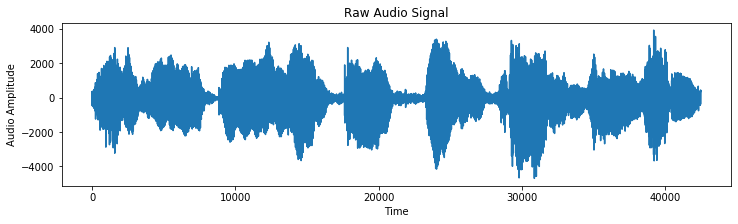

Shape of MFCC: (265, 13)


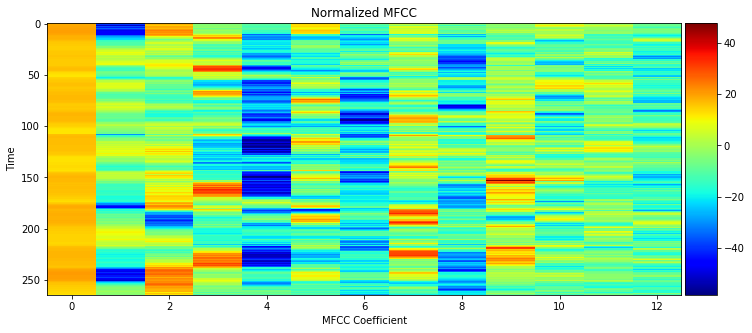

In [10]:
def visualize(index, source='train', mfcc_dim=mfcc_dim):
    if source == 'train':
        path = train_files[index]
    else:
        path = dev_files[index]
    print(path)
        
    audio, slices = load_and_trim(path)
    print('Duration: %.2f s' % (audio.shape[0] / sr))
    plt.figure(figsize=(12, 3))
    plt.plot(np.arange(len(audio)), audio)
    plt.title('Raw Audio Signal')
    plt.xlabel('Time')
    plt.ylabel('Audio Amplitude')
    plt.show()
    
    feature = mfcc(audio, sr, numcep=mfcc_dim)
    print('Shape of MFCC:', feature.shape)
    fig = plt.figure(figsize=(12, 5))
    ax = fig.add_subplot(111)
    im = ax.imshow(feature, cmap=plt.cm.jet, aspect='auto')
    plt.title('Normalized MFCC')
    plt.ylabel('Time')
    plt.xlabel('MFCC Coefficient')
    plt.colorbar(im, cax=make_axes_locatable(ax).append_axes('right', size='5%', pad=0.05))
    ax.set_xticks(np.arange(0, 13, 2), minor=False);
    plt.show()
    
    wav_path = 'example.wav'
    pcm2wav(path, wav_path)
    
    return wav_path

Audio(visualize(66))

##### MFCC特征计算


18879 1632


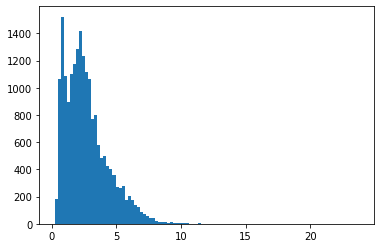

In [11]:
# 数据整理
X_train = []
X_dev = []
Y_train = []
Y_dev = []
lengths = []  # 时间长度

for i in tqdm_notebook(range(len(train_files))):
    path = train_files[i]
    audio, slices = load_and_trim(path)
    lengths.append(audio.shape[0] / sr)
    for s in slices:
        X_train.append(mfcc(s, sr, numcep=mfcc_dim))
        Y_train.append(labels['train'][i])

for i in tqdm_notebook(range(len(dev_files))):
    path = dev_files[i]
    audio, slices = load_and_trim(path)
    lengths.append(audio.shape[0] / sr)
    for s in slices:
        X_dev.append(mfcc(s, sr, numcep=mfcc_dim))
        Y_dev.append(labels['dev'][i])

print(len(X_train), len(X_dev))
plt.hist(lengths, bins=100)
plt.show()

In [20]:
with open('resources.pkl', 'wb') as fw:
    pickle.dump([class2id, id2class, mfcc_mean, mfcc_std], fw)

##### X data与Y data

In [12]:
# 特征归一化
samples = np.vstack(X_train)
mfcc_mean = np.mean(samples, axis=0)
mfcc_std = np.std(samples, axis=0)
print(mfcc_mean)
print(mfcc_std)

X_train = [(x - mfcc_mean) / (mfcc_std + 1e-14) for x in X_train]
X_dev = [(x - mfcc_mean) / (mfcc_std + 1e-14) for x in X_dev]

maxlen = np.max([x.shape[0] for x in X_train + X_dev])
X_train = pad_sequences(X_train, maxlen, 'float32', padding='post', value=0.0)
X_dev = pad_sequences(X_dev, maxlen, 'float32', padding='post', value=0.0)
print(X_train.shape, X_dev.shape)

[ 16.58265829  -8.82345628  -3.05719504  -7.55755549 -13.02245262
  -9.2274836  -12.65317813  -5.70805171  -6.46977352  -1.4675787
  -4.08433965  -2.59217447  -7.03203895]
[ 2.19202495 13.58902426 13.42265523 15.440204   15.94034678 15.85397706
 15.06883656 14.45123701 13.4038407  12.85218419 12.33629292 11.7761117
 10.19249212]
(18879, 299, 13) (1632, 299, 13)


In [13]:
# 标签处理
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

le = LabelEncoder()
Y_train = le.fit_transform(Y_train)
Y_dev = le.transform(Y_dev)
print(le.classes_)

class2id = {c: i for i, c in enumerate(le.classes_)}
id2class = {i: c for i, c in enumerate(le.classes_)}

num_class = len(le.classes_)
Y_train = to_categorical(Y_train, num_class)
Y_dev = to_categorical(Y_dev, num_class)
print(Y_train.shape, Y_dev.shape)

['changsha' 'nanchang' 'shanghai']
(18879, 3) (1632, 3)


##### batch generator

In [15]:
batch_size = 16
def batch_generator(x, y, batch_size=batch_size): 
    offset = 0
    while True:
        offset += batch_size
        
        if offset == batch_size or offset >= len(x):
            x, y = shuffle(x, y)
            offset = batch_size
            
        X_batch = x[offset - batch_size: offset]    
        Y_batch = y[offset - batch_size: offset]
        
        yield (X_batch, Y_batch)

#### Model

不再使用CTC，只需要简单使用categorical_crossentropy

In [16]:
epochs = 10
num_blocks = 3
filters = 128
drop_rate = 0.25
batch_size = 16
mfcc_dim = 13

In [17]:
def conv1d(inputs, filters, kernel_size, dilation_rate):
    return Conv1D(filters=filters,
                  kernel_size=kernel_size,
                  strides=1,
                  padding='causal',
                  activation=None,
                  dilation_rate=dilation_rate)(inputs)


def batchnorm(inputs):
    return BatchNormalization()(inputs)


def activation(inputs, activation):
    return Activation(activation)(inputs)


def res_block(inputs, filters, kernel_size, dilation_rate):
    hf = activation(
        batchnorm(conv1d(inputs, filters, kernel_size, dilation_rate)), 'tanh')
    hg = activation(
        batchnorm(conv1d(inputs, filters, kernel_size, dilation_rate)),
        'sigmoid')
    h0 = Multiply()([hf, hg])
    
    # to next layer
    ha = activation(batchnorm(conv1d(h0, filters, 1, 1)), 'tanh')
    # to output feature extraction
    hs = activation(batchnorm(conv1d(h0, filters, 1, 1)), 'tanh')

    return Add()([ha, inputs]), hs

In [18]:
X = Input(shape=(None, mfcc_dim,), dtype='float32')

h0 = activation(batchnorm(conv1d(X, filters, 1, 1)), 'tanh')

# 不同大小空洞卷积的block
shortcut = []
for i in range(num_blocks):
    for r in [1, 2, 4, 8, 16]:
        h0, s = res_block(h0, filters, 7, r)
        shortcut.append(s)
        
# 不同层次的特征抽取结合
h1 = activation(Add()(shortcut), 'relu')
# batch_size, seq_len, filters
h1 = activation(batchnorm(conv1d(h1, filters, 1, 1)), 'relu') 
# batch_size, seq_len, num_class
h1 = batchnorm(conv1d(h1, num_class, 1, 1))
# GlobalMaxPooling1D：输出num_class大小的预测结果
# 可以先GlobalMaxPooling1D，再dense到num_class个预测结果
h1 = GlobalMaxPooling1D()(h1) # batch_size, num_class

Y = activation(h1, 'softmax')

Instructions for updating:
Colocations handled automatically by placer.


In [21]:
# loss
optimizer = Adam(lr=0.01, clipnorm=5)
model = Model(inputs=X, outputs=Y)
model.compile(loss='categorical_crossentropy',
                         optimizer=optimizer,
                         metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='classification.h5', verbose=0)
lr_decay = ReduceLROnPlateau(monitor='loss',
                                                    factor=0.2,
                                                    patience=1,
                                                    min_lr=0.000)

history = model.fit_generator(generator=batch_generator(X_train, Y_train),
                                                 steps_per_epoch=len(X_train) // batch_size,
                                                 epochs=epochs,
                                                 validation_data=batch_generator(X_dev, Y_dev),
                                                 validation_steps=len(X_dev) // batch_size,
                                                 callbacks=[checkpointer, lr_decay],
                                                 verbose=2)

Epoch 1/10
 - 381s - loss: 0.5160 - acc: 0.7856 - val_loss: 0.8899 - val_acc: 0.7157
Epoch 2/10
 - 352s - loss: 0.2618 - acc: 0.9028 - val_loss: 0.6722 - val_acc: 0.8499
Epoch 3/10
 - 354s - loss: 0.1668 - acc: 0.9398 - val_loss: 0.4348 - val_acc: 0.8585
Epoch 4/10
 - 356s - loss: 0.1245 - acc: 0.9563 - val_loss: 0.2857 - val_acc: 0.9001
Epoch 5/10
 - 355s - loss: 0.1041 - acc: 0.9649 - val_loss: 0.5023 - val_acc: 0.8787
Epoch 6/10
 - 355s - loss: 0.0874 - acc: 0.9695 - val_loss: 0.7569 - val_acc: 0.8609
Epoch 7/10
 - 357s - loss: 0.0695 - acc: 0.9772 - val_loss: 0.6126 - val_acc: 0.8787
Epoch 8/10
 - 353s - loss: 0.0598 - acc: 0.9795 - val_loss: 0.4438 - val_acc: 0.8928
Epoch 9/10
 - 360s - loss: 0.0596 - acc: 0.9797 - val_loss: 0.4597 - val_acc: 0.8787
Epoch 10/10
 - 356s - loss: 0.0512 - acc: 0.9819 - val_loss: 0.7216 - val_acc: 0.8830


#### Test

In [1]:
import numpy as np
from keras.models import load_model
from keras.preprocessing.sequence import pad_sequences
import librosa
from python_speech_features import mfcc
import pickle
import wave
import glob

Using TensorFlow backend.


In [2]:
with open('resources.pkl', 'rb') as fr:
    [class2id, id2class, mfcc_mean, mfcc_std] = pickle.load(fr)

model = load_model('classification.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [4]:
# 测试数据集中的结果，可以替换为自己的数据
paths = glob.glob('data/*/dev/*/*/*.pcm')
path = np.random.choice(paths, 1)[0]
label = path.split('\\')[1]
print(label, path)

shanghai data\shanghai\dev\speaker34\long\shanghai_dev_speaker34_015.pcm


In [7]:
mfcc_dim = 13
sr = 16000
min_length = 1 * sr
slice_length = 3 * sr

def load_and_trim(path, sr=16000):
    audio = np.memmap(path, dtype='h', mode='r')
    audio = audio[2000:-2000]
    audio = audio.astype(np.float32)
    energy = librosa.feature.rms(audio)
    frames = np.nonzero(energy >= np.max(energy) / 5)
    indices = librosa.core.frames_to_samples(frames)[1]
    audio = audio[indices[0]:indices[-1]] if indices.size else audio[0:0]
    
    slices = []
    for i in range(0, audio.shape[0], slice_length):
        s = audio[i: i + slice_length]
        slices.append(s)
    
    return audio, slices

In [8]:
# 处理音频
audio, slices = load_and_trim(path)
X_data = [mfcc(s, sr, numcep=mfcc_dim) for s in slices]
X_data = [(x - mfcc_mean) / (mfcc_std + 1e-14) for x in X_data]

maxlen = np.max([x.shape[0] for x in X_data])
X_data = pad_sequences(X_data, maxlen, 'float32', padding='post', value=0.0)

In [9]:
# 预测
prob = model.predict(X_data)
prob = np.mean(prob, axis=0)

pred = np.argmax(prob)
prob = prob[pred]

pred = id2class[pred]

print('True:', label)
print('Pred:', pred, 'Confidence:', prob)

True: shanghai
Pred: shanghai Confidence: 0.85094905
